In [49]:
import xarray as xr 
import numpy as np 

import iris
import efp_saffin as saff 
import datetime as dt 

import sys
sys.path.append('/home/users/cturrell/documents/eddy_feedback/') 
import functions.eddy_feedback as ef 
import functions.data_wrangling as data 

In [50]:
ds = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/reanalysis_data/srip_datasets/jra55_TEM_ubar_div1.nc',
                            parallel=True, chunks={'time': 31})

ds = ds.sel(time=slice('1958-03', '2016-11'))
ds = ds.sel(latitude=slice(25,72))
ds 

<xarray.Dataset>
Dimensions:   (time: 705, pressure: 22, latitude: 19)
Coordinates:
  * time      (time) datetime64[ns] 1958-03-14T09:00:00 ... 2016-11-13T21:00:00
  * pressure  (pressure) float32 1e+03 925.0 850.0 700.0 ... 5.0 3.0 2.0 1.0
  * latitude  (latitude) float32 25.0 27.5 30.0 32.5 ... 62.5 65.0 67.5 70.0
Data variables:
    ubar      (time, pressure, latitude) float32 dask.array<chunksize=(29, 22, 19), meta=np.ndarray>
    div1_pr   (time, pressure, latitude) float32 dask.array<chunksize=(29, 22, 19), meta=np.ndarray>
    div1_qg   (time, pressure, latitude) float32 dask.array<chunksize=(29, 22, 19), meta=np.ndarray>

In [51]:
# subset to DJF
winter_months = ds.time.dt.month.isin([12,1,2])
djf = ds.sel(time=winter_months)
djf  

<xarray.Dataset>
Dimensions:   (time: 174, pressure: 22, latitude: 19)
Coordinates:
  * time      (time) datetime64[ns] 1958-12-14T09:00:00 ... 2016-02-13T09:00:00
  * pressure  (pressure) float32 1e+03 925.0 850.0 700.0 ... 5.0 3.0 2.0 1.0
  * latitude  (latitude) float32 25.0 27.5 30.0 32.5 ... 62.5 65.0 67.5 70.0
Data variables:
    ubar      (time, pressure, latitude) float32 dask.array<chunksize=(6, 22, 19), meta=np.ndarray>
    div1_pr   (time, pressure, latitude) float32 dask.array<chunksize=(6, 22, 19), meta=np.ndarray>
    div1_qg   (time, pressure, latitude) float32 dask.array<chunksize=(6, 22, 19), meta=np.ndarray>

In [52]:
# extract ubar and div1 DataArrays
ubar = djf.ubar 
div1 = djf.div1_pr 

# convert xarray to iris cubes
cube_ubar = djf.ubar.to_iris()
cube_div1 = djf.div1_pr.to_iris()


# take a pressure slice to reduce dataset
ubar = ubar.sel(pressure=500.) 
div1 = div1.sel(pressure=500.)

cube_ubar = cube_ubar.extract(iris.Constraint(air_pressure=500.))
cube_div1 = cube_div1.extract(iris.Constraint(air_pressure=500.)) 

### Check values of two different systems

So far, both datasets are equal as expected.

In [53]:
np.testing.assert_allclose(ubar.values, cube_ubar.data)
np.testing.assert_allclose(div1.values, cube_div1.data) 

### Check unchanged averaging methods

In [54]:
ubar = data.annual_mean(ubar)
div1 = data.annual_mean(div1)

# calculate seasonal mean of cube (needs to be subsetted to DJF already) 
span = dt.timedelta(days=28)
cube_ubar = saff.seasonal_mean(cube_ubar, span)
cube_div1 = saff.seasonal_mean(cube_div1, span) 

THESE HAVE A 100% DIFFERENCE:

In [55]:
# np.testing.assert_allclose(ubar.values, cube_ubar.data)
# np.testing.assert_allclose(div1.values, cube_div1.data) 

# Seasonal means

First we will compare the two different methods, then see if a weighted seasonal average is required.

In [56]:
ds = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/reanalysis_data/srip_datasets/jra55_TEM_ubar_div1.nc',
                            parallel=True, chunks={'time': 31})

ds = ds.sel(time=slice('1958-03', '2016-11'))
ds = ds.sel(latitude=slice(25,72))

### Take seasonal average

In [57]:
# resample data to start 1st Dec
seasonal = ds.resample(time='QS-DEC').mean('time')

# take winter season of set and cut off last 'season' 
seasonal = seasonal.sel(time=seasonal.time.dt.month.isin([12]))

seasonal = seasonal.sel(pressure=500.)
seasonal 

<xarray.Dataset>
Dimensions:   (time: 58, latitude: 19)
Coordinates:
    pressure  float32 500.0
  * latitude  (latitude) float32 25.0 27.5 30.0 32.5 ... 62.5 65.0 67.5 70.0
  * time      (time) datetime64[ns] 1958-12-01 1959-12-01 ... 2015-12-01
Data variables:
    ubar      (time, latitude) float32 dask.array<chunksize=(5, 19), meta=np.ndarray>
    div1_pr   (time, latitude) float32 dask.array<chunksize=(5, 19), meta=np.ndarray>
    div1_qg   (time, latitude) float32 dask.array<chunksize=(5, 19), meta=np.ndarray>

In [58]:
# calculate seasonal mean (dataset is already subsetted to DJF)
ubar_seasonal = seasonal.ubar
div1_seasonal = seasonal.div1_pr 


# calculate seasonal mean of cube (needs to be subsetted to DJF already)
span = dt.timedelta(days=28)
cube_ubar = saff.seasonal_mean(cube_ubar, span)
cube_div1 = saff.seasonal_mean(cube_div1, span) 

### Check Seasonal mean differences

- DATA IS PRETTY DAMN CLOSE... (had to reduce tolerance)

- Default tolerance was ~10% accurate

Allows better tolerance when slicing is performed beforehand.
- There was marginal improvement when slicing time
- Major changes came with latitude slicing

In [59]:
# np.testing.assert_allclose(ubar_seasonal.values, cube_ubar.data)
# np.testing.assert_allclose(div1_seasonal.values, cube_div1.data)

# reduce the tolerance
np.testing.assert_allclose(ubar_seasonal.values, cube_ubar.data, rtol=1e-06)
np.testing.assert_allclose(div1_seasonal.values, cube_div1.data, rtol=1e-05) # 5% mismatch when 1e-05

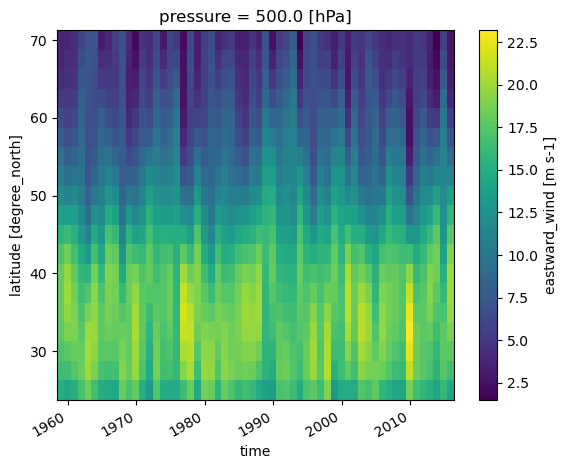

In [60]:
ubar_seasonal.transpose().plot()

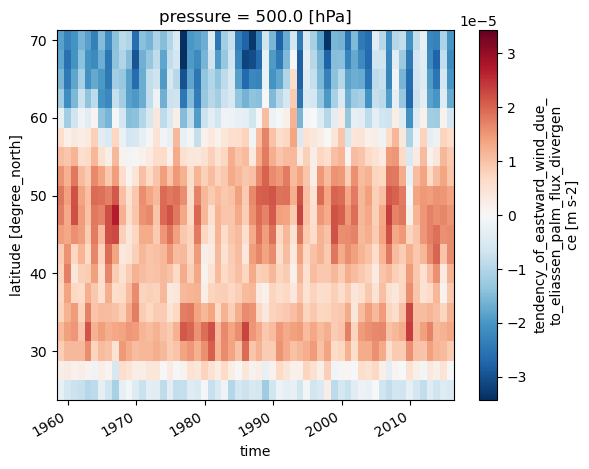

In [61]:
div1_seasonal.transpose().plot()

In [62]:
EFP = ef.calculate_efp_sliced(ubar_seasonal, div1_seasonal) 
EFP.values 

array(0.39410558)

## Weighted seasonal means

Difference could also be due to the different labelling of the year of the season.

Inspiration: 
- https://docs.xarray.dev/en/stable/examples/monthly-means.html 
- https://docs.xarray.dev/en/latest/examples/area_weighted_temperature.html  

In [63]:
ds = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/reanalysis_data/srip_datasets/jra55_TEM_ubar_div1.nc',
                            parallel=True, chunks={'time': 31})

ds = ds.sel(time=slice('1958-03', '2016-11'))
ds = ds.sel(latitude=slice(25,72))
ds 

<xarray.Dataset>
Dimensions:   (time: 705, pressure: 22, latitude: 19)
Coordinates:
  * time      (time) datetime64[ns] 1958-03-14T09:00:00 ... 2016-11-13T21:00:00
  * pressure  (pressure) float32 1e+03 925.0 850.0 700.0 ... 5.0 3.0 2.0 1.0
  * latitude  (latitude) float32 25.0 27.5 30.0 32.5 ... 62.5 65.0 67.5 70.0
Data variables:
    ubar      (time, pressure, latitude) float32 dask.array<chunksize=(29, 22, 19), meta=np.ndarray>
    div1_pr   (time, pressure, latitude) float32 dask.array<chunksize=(29, 22, 19), meta=np.ndarray>
    div1_qg   (time, pressure, latitude) float32 dask.array<chunksize=(29, 22, 19), meta=np.ndarray>

In [64]:
days = ds.time.dt.days_in_month

ds_weighted = (ds*days).resample(time='QS-DEC').sum() / days.resample(time='QS-DEC').sum()
ds_weighted  

<xarray.Dataset>
Dimensions:   (pressure: 22, latitude: 19, time: 235)
Coordinates:
  * pressure  (pressure) float32 1e+03 925.0 850.0 700.0 ... 5.0 3.0 2.0 1.0
  * latitude  (latitude) float32 25.0 27.5 30.0 32.5 ... 62.5 65.0 67.5 70.0
  * time      (time) datetime64[ns] 1958-03-01 1958-06-01 ... 2016-09-01
Data variables:
    ubar      (time, pressure, latitude) float64 dask.array<chunksize=(20, 22, 19), meta=np.ndarray>
    div1_pr   (time, pressure, latitude) float64 dask.array<chunksize=(20, 22, 19), meta=np.ndarray>
    div1_qg   (time, pressure, latitude) float64 dask.array<chunksize=(20, 22, 19), meta=np.ndarray>

In [65]:
# take winter season of set and cut off last 'season' 
seasonal = ds_weighted.sel(time=ds_weighted.time.dt.month.isin([12])) 
seasonal = seasonal.sel(latitude=slice(25,72))
seasonal = seasonal.sel(pressure=500.)
seasonal 

<xarray.Dataset>
Dimensions:   (latitude: 19, time: 58)
Coordinates:
    pressure  float32 500.0
  * latitude  (latitude) float32 25.0 27.5 30.0 32.5 ... 62.5 65.0 67.5 70.0
  * time      (time) datetime64[ns] 1958-12-01 1959-12-01 ... 2015-12-01
Data variables:
    ubar      (time, latitude) float64 dask.array<chunksize=(5, 19), meta=np.ndarray>
    div1_pr   (time, latitude) float64 dask.array<chunksize=(5, 19), meta=np.ndarray>
    div1_qg   (time, latitude) float64 dask.array<chunksize=(5, 19), meta=np.ndarray>

In [66]:
ubar_seasonal = seasonal.ubar 
div1_seasonal = seasonal.div1_pr

In [67]:
EFP = ef.calculate_efp_sliced(ubar_seasonal, div1_seasonal) 
EFP.values 

array(0.39517249)

In [68]:
# reduce the tolerance
np.testing.assert_allclose(ubar_seasonal.values, cube_ubar.data, rtol=1e-06)
np.testing.assert_allclose(div1_seasonal.values, cube_div1.data, rtol=1e-05) # 5% mismatch when 1e-05

AssertionError: 
Not equal to tolerance rtol=1e-06, atol=0

Mismatched elements: 1102 / 1102 (100%)
Max absolute difference: 0.17187285
Max relative difference: 0.04720074
 x: array([[15.008718, 16.402296, 17.070447, ...,  4.030726,  3.549601,
         3.469444],
       [14.364539, 16.517746, 17.590744, ...,  4.67645 ,  4.377515,...
 y: MaskedArray([[15.06775 , 16.45442 , 17.096159, ...,  4.139095,  3.690396,
               3.641317],
             [14.406428, 16.555387, 17.636524, ...,  4.697521,  4.385302,...